In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
np.random.seed(7)

In [4]:
data_path = "/content/gdrive/My Drive/Project/Stocks/"

In [5]:
def get_all_files(data_path=data_path):
    all_files = []

    for file in os.listdir(data_path)[:100]:
        f = open(data_path+file)
        if len(f.readlines()) > 100: 
            all_files.append(data_path+file)
        f.close()
    
    return all_files

all_files = get_all_files()

In [6]:
n = len(all_files)

all_files = np.array(all_files, dtype=str)
np.random.shuffle(all_files)

training_files = all_files[:int(n*0.6)] 
validation_files = all_files[int(n*0.6):int(n*0.8)]
test_files = all_files[int(n*0.8):]

In [7]:
def transform_data(file, K):
    X, T = [], []

    f = open(file, "r")

    data = []
    for line in f.readlines()[-100:]:
        line = line.split(",")[1:-2]

        data.append(line)
        if len(data) == K+1:
            x = np.array(data[:-1], dtype=float)
            X.append(x)
            T.append(float(data[-1][-1]))

            data = data[1:]

    f.close()
    
    return torch.tensor(X, dtype=torch.float), torch.tensor(T, dtype=torch.float)

In [8]:
class StocksRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(StocksRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        s1, s2, s3 = x.shape
        x = x.reshape(s1, s2*s3)
        min, max = torch.amin(x, axis=1), torch.amax(x, axis=1)
        x = (x-min[:, np.newaxis]) / (max[:, np.newaxis] - min[:, np.newaxis])
        x = x.reshape(s1, s2, s3)
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return ((out.reshape(-1) * (max-min)) + min).reshape(-1, 1)

class StocksLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(StocksLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        s1, s2, s3 = x.shape
        x = x.reshape(s1, s2*s3)
        min, max = torch.amin(x, axis=1), torch.amax(x, axis=1)
        x = (x-min[:, np.newaxis]) / (max[:, np.newaxis] - min[:, np.newaxis])
        x = x.reshape(s1, s2, s3)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return ((out.reshape(-1) * (max-min)) + min).reshape(-1, 1)


In [9]:
def get_mean_squared_error(model, files, K):
    error = 0
    total = 0

    for f in files:
        x, t = transform_data(f, K)

        s1, s2, s3 = x.shape
        x = x.reshape(s1, s2*s3)
        min, max = torch.amin(x, axis=1), torch.amax(x, axis=1)
        x = (x-min[:, np.newaxis]) / (max[:, np.newaxis] - min[:, np.newaxis])
        x = x.reshape(s1, s2, s3)
        t = (t-min) / (max - min)

        output = model(x).reshape(-1)
        error += int(sum((output - t)**2).detach())
        total += output.shape[0]

    return error / total

In [10]:
def train_rnn_network(model, train, valid, num_epochs, batch_size, learning_rate, K, name):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []

    iter_x = []
    iter_t = []
    for f in train:
        x, t = transform_data(f, K)
        iter_x.append(x)
        iter_t.append(t)

    train_data_x = torch.concat(iter_x, 0)
    train_data_t = torch.concat(iter_t, 0)

    for epoch in range(num_epochs):

        p = np.random.permutation(train_data_t.shape[0])
        X, T = train_data_x[p], train_data_t[p]

        for i in range(0, int(T.shape[0]), batch_size):
            batch_x = X[i: (i+batch_size)]
            batch_t = T[i: (i+batch_size)]
            pred = model(batch_x)
            loss = criterion(pred, batch_t.reshape(-1, 1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_mean_squared_error(model, train, K))
        valid_acc.append(get_mean_squared_error(model, valid, K))
        if (epoch+1) % 10 == 0:
            print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
                epoch+1, loss, train_acc[-1], valid_acc[-1]))

    plt.title(name + " Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")
    plt.legend(loc='best')
    plt.savefig(name.replace(" ", "")+".png")
    plt.show()

<ipython-input-7-1a1e3b3329d3>:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.tensor(X, dtype=torch.float), torch.tensor(T, dtype=torch.float)


Epoch 10; Loss 0.531985; Train Acc 0.344250; Val Acc 0.353216
Epoch 20; Loss 0.656446; Train Acc 0.268031; Val Acc 0.263743
Epoch 30; Loss 0.981256; Train Acc 0.243665; Val Acc 0.230409
Epoch 40; Loss 0.568373; Train Acc 0.240351; Val Acc 0.225146
Epoch 50; Loss 0.636992; Train Acc 0.237037; Val Acc 0.221053
Epoch 60; Loss 0.670290; Train Acc 0.234503; Val Acc 0.217544
Epoch 70; Loss 0.384991; Train Acc 0.230604; Val Acc 0.213450
Epoch 80; Loss 0.499139; Train Acc 0.227096; Val Acc 0.211111
Epoch 90; Loss 0.530176; Train Acc 0.224951; Val Acc 0.208187
Epoch 100; Loss 1.063508; Train Acc 0.222222; Val Acc 0.205848


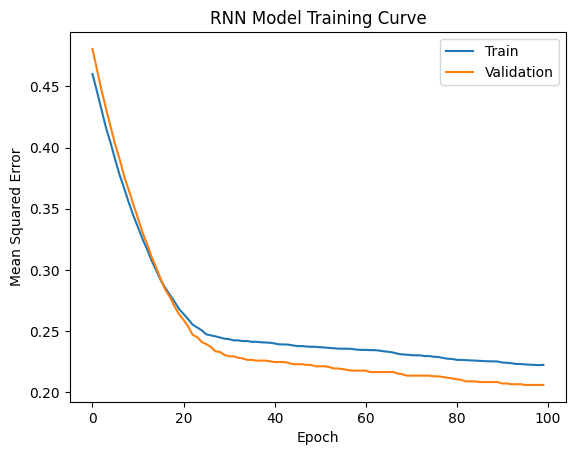

Test Data Accuracy:  0.19168975069252078


In [11]:
modelRNN = StocksRNN(4, 150)
train_rnn_network(modelRNN, 
                  training_files, 
                  validation_files, 
                  num_epochs=100, 
                  batch_size=500, 
                  learning_rate=1e-5,
                  K=5, 
                  name="RNN Model")
print("Test Data Accuracy: ", get_mean_squared_error(modelRNN, test_files, 5))

Epoch 10; Loss 1.664886; Train Acc 0.476413; Val Acc 0.499415
Epoch 20; Loss 0.798636; Train Acc 0.441326; Val Acc 0.460819
Epoch 30; Loss 1.038126; Train Acc 0.406043; Val Acc 0.421637
Epoch 40; Loss 0.772814; Train Acc 0.371150; Val Acc 0.381287
Epoch 50; Loss 0.602107; Train Acc 0.336647; Val Acc 0.343860
Epoch 60; Loss 0.782981; Train Acc 0.305653; Val Acc 0.308187
Epoch 70; Loss 0.359595; Train Acc 0.279532; Val Acc 0.276608
Epoch 80; Loss 0.533367; Train Acc 0.262768; Val Acc 0.255556
Epoch 90; Loss 0.253839; Train Acc 0.254581; Val Acc 0.243860
Epoch 100; Loss 1.204947; Train Acc 0.252632; Val Acc 0.239181


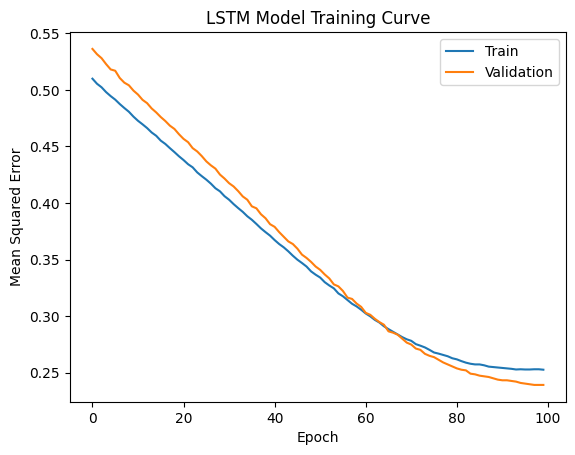

Test Data Accuracy:  0.22160664819944598


In [12]:
modelLSTM = StocksLSTM(4, 150)
train_rnn_network(modelLSTM, 
                  training_files, 
                  validation_files, 
                  num_epochs=100, 
                  batch_size=500, 
                  learning_rate=1e-5,
                  K=5, 
                  name="LSTM Model")
print("Test Data Accuracy: ", get_mean_squared_error(modelLSTM, test_files, 5))

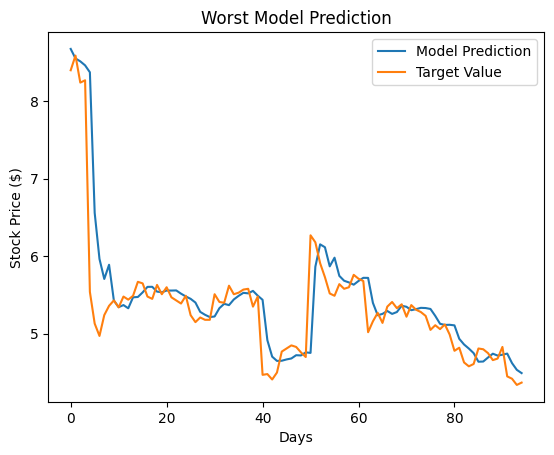

Worst Model Prediction Error:  0.6526315789473685


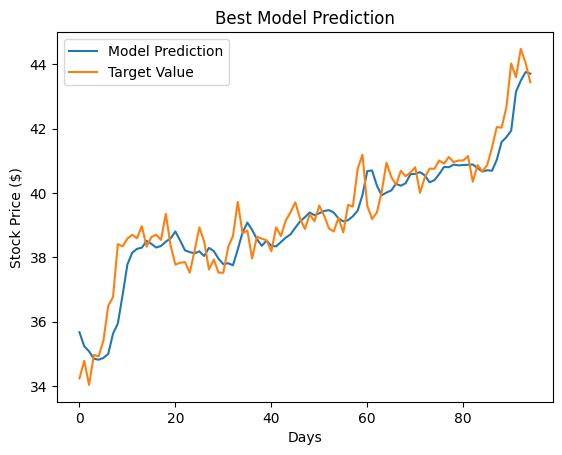

Best Model Prediction Error:  0.12631578947368421


In [13]:
def goodBadExample(model, K, test_files=test_files):
    bad_error, bad_file = float("-inf"), ""
    good_error, good_file = float("inf"), ""

    for f in test_files:
        error = get_mean_squared_error(modelLSTM, [f], K)
        if error > bad_error:
            bad_error = error
            bad_file = f
        
        if error < good_error:
            good_error = error
            good_file = f
    
    X, T = transform_data(bad_file, K)
    Y = model(X)

    plt.title("Worst Model Prediction")
    plt.ylabel("Stock Price ($)")
    plt.xlabel("Days")
    plt.plot(np.arange(len(Y)), Y.detach().numpy(), label="Model Prediction")
    plt.plot(np.arange(len(T)), T, label="Target Value")
    plt.legend()
    plt.savefig("WorstModelPrediction.png")
    plt.show()

    print("Worst Model Prediction Error: ", 
          get_mean_squared_error(modelLSTM, [bad_file], K))

    X, T = transform_data(good_file, K)
    Y = model(X)

    plt.title("Best Model Prediction")
    plt.ylabel("Stock Price ($)")
    plt.xlabel("Days")
    plt.plot(np.arange(len(Y)), Y.detach().numpy(), label="Model Prediction")
    plt.plot(np.arange(len(T)), T, label="Target Value")
    plt.legend()
    plt.savefig("BestModelPrediction.png")
    plt.show()

    print("Best Model Prediction Error: ", 
          get_mean_squared_error(modelLSTM, [good_file], K))

goodBadExample(modelRNN, 5, test_files=test_files)